In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import json

notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print(sys.path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%reload_ext autoreload
%autoreload 2

['/mnt/ceph/users/blyo1/projects', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python310.zip', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/lib-dynload', '', '/mnt/home/blyo1/venvs/py310/lib/python3.10/site-packages']


# data

In [ ]:
# hierarchical dataset 2

from a_datasets.hdisks1 import random_two_disk_dataset
# random sample of disks
data = random_two_disk_dataset(
    delta_id=.2,
    d=10, outer_radius=4, transition_width=2,
    img_size=32, num_imgs=5e4,
    # ib=0.2
)[0]

In [36]:
# hierarchical dataset 3

from a_datasets.hdisks3 import random_two_disk_dataset

data = random_two_disk_dataset(
    img_size=32,
    outer_radius=4,
    transition_width=2,
    d=10,
    num_imgs=5e4
)[0]

In [37]:
from a_datasets.disks import DiskDataset
from torch.utils.data import DataLoader
dataset = DiskDataset(data)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

# hVAE

In [ ]:
from b_models.lvae import ConvBlock, TopDownBlock, BottomUpBlock, LadderVAE

input_dim = 32
num_blocks = 2
channels = [1, 32, 32]
z_dims = [6, 4]

lvae = LadderVAE(input_dim, z_dims, channels, num_blocks)
# count number of parameters in the model
from utils.base_utils import count_parameters
print("Number of trainable parameters:", count_parameters(lvae))

Number of trainable parameters: 133465


In [59]:
test_input = torch.randn(1, 1, 32, 32)

lvae(test_input)

tensor([[[[ 0.1753,  0.1290,  0.1268,  ...,  0.2817,  0.1362,  0.1972],
          [ 0.0407,  0.1190, -0.3664,  ..., -0.1548, -0.1031,  0.3105],
          [ 0.0785, -0.2666, -0.3941,  ..., -0.4485, -0.0156,  0.0159],
          ...,
          [ 0.2149, -0.0149,  0.2150,  ..., -0.3105,  0.2574, -0.3211],
          [ 0.2158,  0.1809,  0.2466,  ...,  0.1854,  0.2427,  0.0733],
          [ 0.2158,  0.2158,  0.2158,  ...,  0.2158,  0.2158,  0.2158]]]],
       grad_fn=<ConvolutionBackward0>)

the problem was that I wasn't using the right spatial dimensions in the TopDown blocks

c_in, c_out has to match each other, like this: c_in = [a, b, c], c_out = [b, c, d] which means we can just use one array that lists the channels and iterate through that.


# train

In [64]:
# now train model
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

n_epochs = 400
kl_schedule = 'constant'
kl_weight = 1e-8
lr = 1e-3

lvae.train()
lvae.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lvae.parameters(), lr=lr)
criterion = nn.MSELoss()


# kl annealing schedule
kl_weight = 0.0
def kl_annealing(epoch, n_epochs_anneal, schedule='linear', end_value = 1.):
    if schedule == 'linear':
        if epoch < n_epochs_anneal:
            kl_weight = end_value * (epoch / n_epochs_anneal)
        else:
            kl_weight = end_value
    elif schedule == 'cosine':
        if epoch < n_epochs_anneal:
            # cosine annealing from 0 to 1
            kl_weight = (1 - 0.5 * (1 + np.cos(np.pi * epoch / n_epochs_anneal))) * end_value
        else:
            kl_weight = end_value
    elif schedule == "constant":
        kl_weight = end_value
    return kl_weight

for epoch in tqdm(range(n_epochs)):
    for batch in dataloader:
        # print("batch shape:", batch.shape)
        batch = batch.to(device)
        optimizer.zero_grad()
        output = lvae(batch)
        # print("output shape:", output.shape)
        mse_loss = criterion(output, batch)
        kl_weight = kl_annealing(epoch, 10, schedule=kl_schedule, end_value=kl_weight)
        kl_loss = lvae.kl
        # Combine losses
        loss = mse_loss + kl_loss * kl_weight
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0 or epoch < 10:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, MSE Loss: {mse_loss.item():.4f}, KL weight: {kl_weight:.4f}, KL Loss: {kl_loss.item():.4f}")

  0%|▎                                                                                                              | 1/400 [00:01<09:27,  1.42s/it]

Epoch 1, Loss: 0.0060, MSE Loss: 0.0060, KL weight: 0.0000, KL Loss: 44.0017


  0%|▌                                                                                                              | 2/400 [00:02<09:26,  1.42s/it]

Epoch 2, Loss: 0.0062, MSE Loss: 0.0062, KL weight: 0.0000, KL Loss: 44.0518


  1%|▊                                                                                                              | 3/400 [00:04<09:23,  1.42s/it]

Epoch 3, Loss: 0.0053, MSE Loss: 0.0053, KL weight: 0.0000, KL Loss: 43.6968


  1%|█                                                                                                              | 4/400 [00:05<09:20,  1.42s/it]

Epoch 4, Loss: 0.0064, MSE Loss: 0.0064, KL weight: 0.0000, KL Loss: 44.3300


  1%|█▍                                                                                                             | 5/400 [00:07<09:18,  1.41s/it]

Epoch 5, Loss: 0.0053, MSE Loss: 0.0053, KL weight: 0.0000, KL Loss: 44.2600


  2%|█▋                                                                                                             | 6/400 [00:08<09:16,  1.41s/it]

Epoch 6, Loss: 0.0058, MSE Loss: 0.0058, KL weight: 0.0000, KL Loss: 44.1502


  2%|█▉                                                                                                             | 7/400 [00:09<09:15,  1.41s/it]

Epoch 7, Loss: 0.0063, MSE Loss: 0.0063, KL weight: 0.0000, KL Loss: 44.4434


  2%|██▏                                                                                                            | 8/400 [00:11<09:14,  1.42s/it]

Epoch 8, Loss: 0.0058, MSE Loss: 0.0058, KL weight: 0.0000, KL Loss: 44.2942


  2%|██▍                                                                                                            | 9/400 [00:12<09:12,  1.41s/it]

Epoch 9, Loss: 0.0072, MSE Loss: 0.0072, KL weight: 0.0000, KL Loss: 44.6244


  2%|██▊                                                                                                           | 10/400 [00:14<09:10,  1.41s/it]

Epoch 10, Loss: 0.0052, MSE Loss: 0.0052, KL weight: 0.0000, KL Loss: 44.4609


  3%|███                                                                                                           | 11/400 [00:15<09:08,  1.41s/it]

Epoch 11, Loss: 0.0060, MSE Loss: 0.0060, KL weight: 0.0000, KL Loss: 44.2883


  5%|█████▊                                                                                                        | 21/400 [00:29<08:54,  1.41s/it]

Epoch 21, Loss: 0.0053, MSE Loss: 0.0053, KL weight: 0.0000, KL Loss: 44.4121


  8%|████████▌                                                                                                     | 31/400 [00:43<08:39,  1.41s/it]

Epoch 31, Loss: 0.0057, MSE Loss: 0.0057, KL weight: 0.0000, KL Loss: 45.0676


 10%|███████████▎                                                                                                  | 41/400 [00:57<08:25,  1.41s/it]

Epoch 41, Loss: 0.0058, MSE Loss: 0.0058, KL weight: 0.0000, KL Loss: 44.5527


 13%|██████████████                                                                                                | 51/400 [01:11<08:11,  1.41s/it]

Epoch 51, Loss: 0.0049, MSE Loss: 0.0049, KL weight: 0.0000, KL Loss: 45.9148


 15%|████████████████▊                                                                                             | 61/400 [01:25<07:57,  1.41s/it]

Epoch 61, Loss: 0.0053, MSE Loss: 0.0053, KL weight: 0.0000, KL Loss: 45.9331


 18%|███████████████████▌                                                                                          | 71/400 [01:40<07:44,  1.41s/it]

Epoch 71, Loss: 0.0067, MSE Loss: 0.0067, KL weight: 0.0000, KL Loss: 46.7265


 20%|██████████████████████▎                                                                                       | 81/400 [01:54<07:31,  1.41s/it]

Epoch 81, Loss: 0.0053, MSE Loss: 0.0053, KL weight: 0.0000, KL Loss: 46.3833


 23%|█████████████████████████                                                                                     | 91/400 [02:08<07:18,  1.42s/it]

Epoch 91, Loss: 0.0050, MSE Loss: 0.0050, KL weight: 0.0000, KL Loss: 47.1917


 25%|███████████████████████████▌                                                                                 | 101/400 [02:22<07:04,  1.42s/it]

Epoch 101, Loss: 0.0056, MSE Loss: 0.0056, KL weight: 0.0000, KL Loss: 47.8191


 28%|██████████████████████████████▏                                                                              | 111/400 [02:36<06:51,  1.42s/it]

Epoch 111, Loss: 0.0056, MSE Loss: 0.0056, KL weight: 0.0000, KL Loss: 47.6512


 30%|████████████████████████████████▉                                                                            | 121/400 [02:50<06:35,  1.42s/it]

Epoch 121, Loss: 0.0053, MSE Loss: 0.0053, KL weight: 0.0000, KL Loss: 47.4964


 33%|███████████████████████████████████▋                                                                         | 131/400 [03:05<06:21,  1.42s/it]

Epoch 131, Loss: 0.0059, MSE Loss: 0.0059, KL weight: 0.0000, KL Loss: 47.2250


 35%|██████████████████████████████████████▍                                                                      | 141/400 [03:19<06:08,  1.42s/it]

Epoch 141, Loss: 0.0057, MSE Loss: 0.0057, KL weight: 0.0000, KL Loss: 49.2951


 38%|█████████████████████████████████████████▏                                                                   | 151/400 [03:33<05:53,  1.42s/it]

Epoch 151, Loss: 0.0054, MSE Loss: 0.0054, KL weight: 0.0000, KL Loss: 47.3736


 40%|███████████████████████████████████████████▊                                                                 | 161/400 [03:47<05:39,  1.42s/it]

Epoch 161, Loss: 0.0053, MSE Loss: 0.0053, KL weight: 0.0000, KL Loss: 48.3697


 43%|██████████████████████████████████████████████▌                                                              | 171/400 [04:01<05:25,  1.42s/it]

Epoch 171, Loss: 0.0049, MSE Loss: 0.0049, KL weight: 0.0000, KL Loss: 49.0599


 45%|█████████████████████████████████████████████████▎                                                           | 181/400 [04:16<05:09,  1.41s/it]

Epoch 181, Loss: 0.0048, MSE Loss: 0.0048, KL weight: 0.0000, KL Loss: 49.4576


 48%|████████████████████████████████████████████████████                                                         | 191/400 [04:30<04:55,  1.41s/it]

Epoch 191, Loss: 0.0054, MSE Loss: 0.0054, KL weight: 0.0000, KL Loss: 49.8557


 50%|██████████████████████████████████████████████████████▊                                                      | 201/400 [04:44<04:39,  1.41s/it]

Epoch 201, Loss: 0.0061, MSE Loss: 0.0061, KL weight: 0.0000, KL Loss: 49.9214


 53%|█████████████████████████████████████████████████████████▍                                                   | 211/400 [04:58<04:26,  1.41s/it]

Epoch 211, Loss: 0.0041, MSE Loss: 0.0041, KL weight: 0.0000, KL Loss: 48.6035


 55%|████████████████████████████████████████████████████████████▏                                                | 221/400 [05:12<04:12,  1.41s/it]

Epoch 221, Loss: 0.0039, MSE Loss: 0.0039, KL weight: 0.0000, KL Loss: 50.5450


 58%|██████████████████████████████████████████████████████████████▉                                              | 231/400 [05:26<03:58,  1.41s/it]

Epoch 231, Loss: 0.0037, MSE Loss: 0.0037, KL weight: 0.0000, KL Loss: 51.2832


 60%|█████████████████████████████████████████████████████████████████▋                                           | 241/400 [05:40<03:44,  1.41s/it]

Epoch 241, Loss: 0.0042, MSE Loss: 0.0042, KL weight: 0.0000, KL Loss: 51.9263


 63%|████████████████████████████████████████████████████████████████████▍                                        | 251/400 [05:54<03:30,  1.41s/it]

Epoch 251, Loss: 0.0037, MSE Loss: 0.0037, KL weight: 0.0000, KL Loss: 51.4284


 65%|███████████████████████████████████████████████████████████████████████                                      | 261/400 [06:08<03:16,  1.41s/it]

Epoch 261, Loss: 0.0042, MSE Loss: 0.0042, KL weight: 0.0000, KL Loss: 52.6734


 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 271/400 [06:22<03:02,  1.42s/it]

Epoch 271, Loss: 0.0039, MSE Loss: 0.0039, KL weight: 0.0000, KL Loss: 51.5974


 70%|████████████████████████████████████████████████████████████████████████████▌                                | 281/400 [06:37<02:48,  1.42s/it]

Epoch 281, Loss: 0.0044, MSE Loss: 0.0044, KL weight: 0.0000, KL Loss: 53.2533


 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 291/400 [06:51<02:34,  1.42s/it]

Epoch 291, Loss: 0.0040, MSE Loss: 0.0040, KL weight: 0.0000, KL Loss: 54.3538


 75%|██████████████████████████████████████████████████████████████████████████████████                           | 301/400 [07:05<02:20,  1.41s/it]

Epoch 301, Loss: 0.0035, MSE Loss: 0.0035, KL weight: 0.0000, KL Loss: 52.8941


 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 311/400 [07:19<02:05,  1.41s/it]

Epoch 311, Loss: 0.0037, MSE Loss: 0.0037, KL weight: 0.0000, KL Loss: 55.0780


 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 321/400 [07:33<01:51,  1.42s/it]

Epoch 321, Loss: 0.0036, MSE Loss: 0.0036, KL weight: 0.0000, KL Loss: 53.0696


 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 331/400 [07:47<01:37,  1.41s/it]

Epoch 331, Loss: 0.0035, MSE Loss: 0.0035, KL weight: 0.0000, KL Loss: 54.6757


 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 341/400 [08:01<01:23,  1.42s/it]

Epoch 341, Loss: 0.0036, MSE Loss: 0.0036, KL weight: 0.0000, KL Loss: 55.1606


 88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 351/400 [08:15<01:09,  1.41s/it]

Epoch 351, Loss: 0.0040, MSE Loss: 0.0040, KL weight: 0.0000, KL Loss: 57.2440


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 361/400 [08:30<00:54,  1.41s/it]

Epoch 361, Loss: 0.0034, MSE Loss: 0.0034, KL weight: 0.0000, KL Loss: 56.8340


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 371/400 [08:44<00:40,  1.41s/it]

Epoch 371, Loss: 0.0032, MSE Loss: 0.0032, KL weight: 0.0000, KL Loss: 57.4257


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 381/400 [08:58<00:26,  1.41s/it]

Epoch 381, Loss: 0.0035, MSE Loss: 0.0035, KL weight: 0.0000, KL Loss: 55.9112


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 391/400 [09:12<00:12,  1.41s/it]

Epoch 391, Loss: 0.0032, MSE Loss: 0.0032, KL weight: 0.0000, KL Loss: 57.2854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [09:25<00:00,  1.41s/it]


In [ ]:
# save model
mode = 'na'
dataset_v = '3'
experiment_v = '3'  # past


save_dir = "./b_models/saved_weights"
if mode == "save":
    torch.save(lvae.state_dict(), os.path.join(save_dir, f'lvae-dataset_{dataset_v}-exp_{experiment_v}.pth'))
    config = {
        "input_dim": input_dim,
        "z_dims": z_dims,
        "lr": lr,
        "channels": channels,
        "num_blocks": num_blocks,
        "kl_schedule": "constant",
        "kl_weight": kl_weight,
        "n_epochs": n_epochs*2,
    }
    json.dump(config, open(os.path.join(save_dir, f'lvae-dataset_{dataset_v}-exp_{experiment_v}.json'), 'w'))
elif mode == "load":
    lvae.load_state_dict(torch.load(os.path.join(save_dir, f'lvae-dataset_{dataset_v}-exp_{experiment_v}.pth')))
else:
    pass

In [ ]:
# load from wandb checkpoints


tensor(-0.8369) tensor(-1.0122) tensor(0.8762) tensor(0.9935)
Test Loss: 0.0057


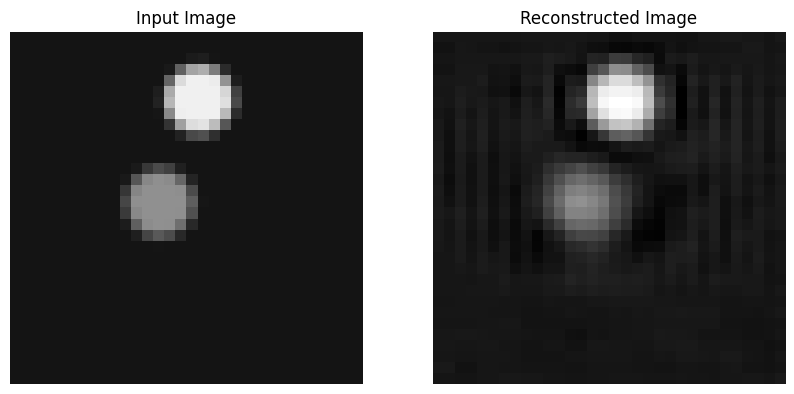

In [66]:
from utils.base_utils import to_01, to_0c
img_idx = 11

test_img = to_0c(data[img_idx]).unsqueeze(1).to(device)

lvae.eval()
xout = lvae(test_img)
xout = xout.detach().cpu()
xin = test_img.cpu()

print(xin.min(), xout.min(), xin.max(), xout.max())
test_loss = criterion(xin, xout).item()
print(f"Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(to_01(xin).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[0].set_title("Input Image")
ax[0].axis("off");

ax[1].imshow(to_01(xout).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[1].set_title("Reconstructed Image")
ax[1].axis("off");



tensor(-0.8567) tensor(-1.0725) tensor(0.8979) tensor(0.9935)
Test Loss: 0.0036


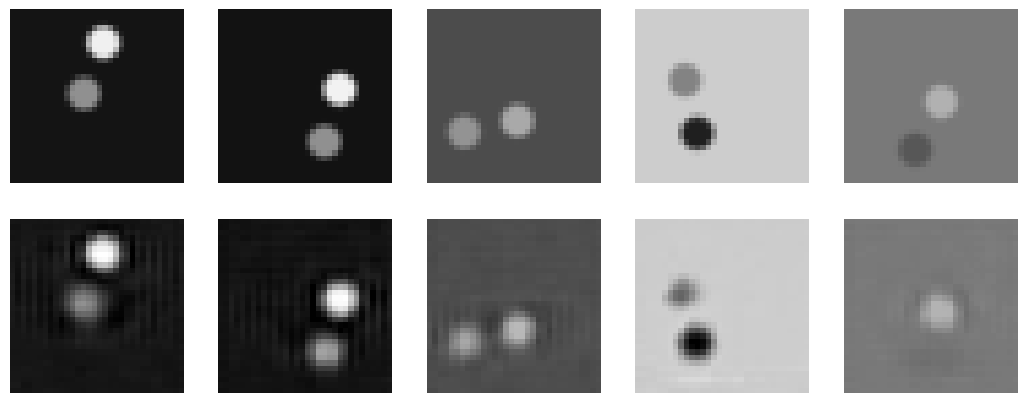

In [67]:
from utils.base_utils import to_01, to_0c
test_img = to_0c(data[11:16]).to(device)

lvae.eval()
out = lvae(test_img)
xout = out.detach().cpu()
xin = test_img.cpu()

print(xin.min(), xout.min(), xin.max(), xout.max())
test_loss = criterion(xin, xout).item()
print(f"Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots(2, len(test_img), figsize=(13, 5))
for i in range(len(test_img)):
    ax[0, i].imshow(to_01(xin[i]).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
    # ax[0, i].set_title("Input Image")
    ax[0, i].axis("off");

    ax[1, i].imshow(to_01(xout[i]).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
    # ax[1, i].set_title("Reconstructed Image")
    ax[1, i].axis("off");


# analysis

is there any way to see how much of the variability is captured by the top vs intermediate latents?

# scrap

In [14]:
import argparse
from b_models.vae import VariableConvEncoder, VariableConvDecoder, VAE, UNetDecoder

num_channels = 1
image_dims = 32
latent_dims = 5

enc = VariableConvEncoder(
    num_channels,
    image_dims,
    latent_dims, 
    channels=[32, 32, 32], 
    bias=True,
)

dec = VariableConvDecoder(
    num_channels,
    image_dims,
    latent_dims,
    channels=[32, 32, 32],  # output_channels, kernel_size, stride, padding
    output_channels=1,
    bias=True,
)

vae = VAE(
    encoder=enc,
    decoder=dec,
    kl_reduction="mean"
)

In [44]:
from b_models.vae import VariableConvEncoder

enc = VariableConvEncoder(num_channels=1, image_dims=32, latent_dims=5, channels=[4, 8, 16])
print(enc.d1_input_dims)
print(enc.d2_input_dims)
print(enc.d3_input_dims)

print(enc.conv_d1.weight.shape)
print(enc.conv_d2.weight.shape)
print(enc.conv_d3.weight.shape)

print(enc.linear_mu.weight.shape)

32
16
8
torch.Size([4, 1, 3, 3])
torch.Size([8, 4, 3, 3])
torch.Size([16, 8, 3, 3])
torch.Size([5, 256])


In [119]:
from b_models.hvae import EncoderConvBlock

example_input = torch.randn(1, 1, 32, 32)
enc_block = EncoderConvBlock(num_channels=1, img_dim=example_input.shape[3], latent_dim=5, channels=[4, 8, 16])

# for i in [0, 2, 4]:
#     print(enc_block.conv_network[i].weight.shape)
# print(enc_block.linear_mu.weight.shape)
d, mu, var = enc_block(example_input)

torch.Size([1, 1, 32, 32])
torch.Size([1, 4, 16, 16])
torch.Size([1, 4, 16, 16])
torch.Size([1, 8, 8, 8])
torch.Size([1, 8, 8, 8])
torch.Size([1, 16, 4, 4])
torch.Size([1, 16, 4, 4])


In [5]:
# testing adaptive avg pool
rand_input = torch.randn(1, 16, 7, 7)
import torch.nn.functional as F
output = F.adaptive_avg_pool2d(rand_input, 1)
print(output.shape)

torch.Size([1, 16, 1, 1])


In [3]:
from b_models.hvae import SpatialEncoderConvBlock

example_input = torch.randn(1, 1, 32, 32)
enc_block = SpatialEncoderConvBlock(num_channels=1, img_dim=example_input.shape[3], latent_dim=5, channels=[4, 8, 16])

# for i in [0, 2, 4]:
#     print(enc_block.conv_network[i].weight.shape)
# print(enc_block.linear_mu.weight.shape)
d, mu, var = enc_block(example_input)

torch.Size([1, 1, 32, 32])
torch.Size([1, 4, 16, 16])
torch.Size([1, 4, 16, 16])
torch.Size([1, 8, 8, 8])
torch.Size([1, 8, 8, 8])
torch.Size([1, 16, 4, 4])
torch.Size([1, 16, 4, 4])
torch.Size([1, 5])


In [94]:
from b_models.hvae import DecoderConvBlock

dec_block = DecoderConvBlock(output_dim=16, latent_dim=5, channels=[16, 8, 4])

example_input = torch.randn(1, 5)
dec_out = dec_block(example_input)
print(dec_out.shape)

# for i in range(len(dec_block.deconv_network)):
#     if hasattr(dec_block.deconv_network[i], 'weight'):
#         print(dec_block.deconv_network[i].weight.shape)

torch.Size([1, 4, 16, 16])


In [117]:
from b_models.hvae import DecoderConvBlock

dec_block = DecoderConvBlock(latent_in_dim=5, latent_out_dim=2, output_dim=8, channels=[4, 8, 16])

example_input = torch.randn(1, 5)
dec_out, _, _ = dec_block(example_input)
print(dec_out.shape)

# for i in range(len(dec_block.deconv_network)):
#     if hasattr(dec_block.deconv_network[i], 'weight'):
#         print(dec_block.deconv_network[i].weight.shape)

torch.Size([1, 5])
torch.Size([1, 16])
torch.Size([1, 16, 1, 1])
torch.Size([1, 8, 2, 2])
torch.Size([1, 8, 2, 2])
torch.Size([1, 4, 4, 4])
torch.Size([1, 4, 4, 4])
torch.Size([1, 16, 8, 8])
torch.Size([1, 16, 8, 8])
end of deconv network
torch.Size([1, 2])
